<a href="https://colab.research.google.com/github/sophiaamirah/Coursera-Imperial-College-London-Mathematics-For-Machine-Learning-Linear-Algebra/blob/master/BraTS_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mount google drive to load data
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import the relevant libraries
import os
import random
import nibabel as nib
import pandas as pd
import math
import numpy as np
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.colors
from keras.models import load_model
from PIL import Image # this is for preserving the r,b,g information while resizing the image
import tensorflow as tf
from tensorflow import keras
from skimage.measure import label, regionprops
from matplotlib.patches import Polygon
from keras.callbacks import EarlyStopping
from keras.metrics import Recall, Precision, MeanIoU
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Cropping2D, UpSampling2D, concatenate, Conv2DTranspose, Dropout
from keras.callbacks import LearningRateScheduler
from skimage.transform import resize

In [ ]:
# Load Excel mapping
excel_mapping_path = '/content/drive/MyDrive/brats/BraTS2023_2017_GLI_Mapping.xlsx'
excel_data = pd.read_excel(excel_mapping_path)

# create variable for base directory where the dataset is stored in Google Drive
base_directory = '/content/drive/MyDrive/brats/train_data/'

# Get a list of all available case IDs
all_case_ids = excel_data['BraTS2023'].dropna().tolist()

# Initialise empty lists to store preprocessed images and labels
all_images = []
all_labels = []

In [ ]:
def data_generator(case_ids, batch_size):
    num_cases = len(case_ids)
    while True:
        for i in range(0, num_cases, batch_size):
            batch_case_ids = case_ids[i:i + batch_size]
            batch_images = []
            batch_masks = []

            #print("Processing batch:", batch_case_ids)

            for patient_id in batch_case_ids:
                #print("Processing patient:", patient_id)

                images = []
                for image_type in ['t1c', 't1n', 't2f', 't2w']:
                    image_filename = f'{patient_id}-{image_type}.nii.gz'
                    image_path = os.path.join(base_directory, patient_id, image_filename)
                    nifti_image = nib.load(image_path)
                    image_data = nifti_image.get_fdata()

                    middle_slice = image_data.shape[2] // 2
                    slice_data = image_data[:, :, middle_slice]

                    resized_slice = resize(slice_data, (128, 128))
                    normalized_slice = (resized_slice - resized_slice.min()) / (resized_slice.max() - resized_slice.min())
                    images.append(normalized_slice)

                seg_filename = f'{patient_id}-seg.nii.gz'
                seg_path = os.path.join(base_directory, patient_id, seg_filename)
                seg_nifti = nib.load(seg_path)
                seg_data = seg_nifti.get_fdata()[:, :, middle_slice]
                resized_seg = resize(seg_data, (128, 128), order=0)
                one_hot_seg = tf.keras.utils.to_categorical(resized_seg, num_classes=num_classes)

               # print("Original Segmentation Mask Shape:", resized_seg.shape)
                #print("One-Hot Encoded Segmentation Mask Shape:", one_hot_seg.shape)

                batch_images.append(np.stack(images, axis=-1))  # Stack images together
                batch_masks.append(one_hot_seg)  # Mask is already one-hot encoded

                #print("Processed patient:", patient_id)

            #print("Batch processed:", batch_case_ids)

            yield np.array(batch_images), np.array(batch_masks)

# Define batch size and other parameters
batch_size = 16
num_classes = 4

# Create the data generator
train_generator = data_generator(all_case_ids, batch_size)


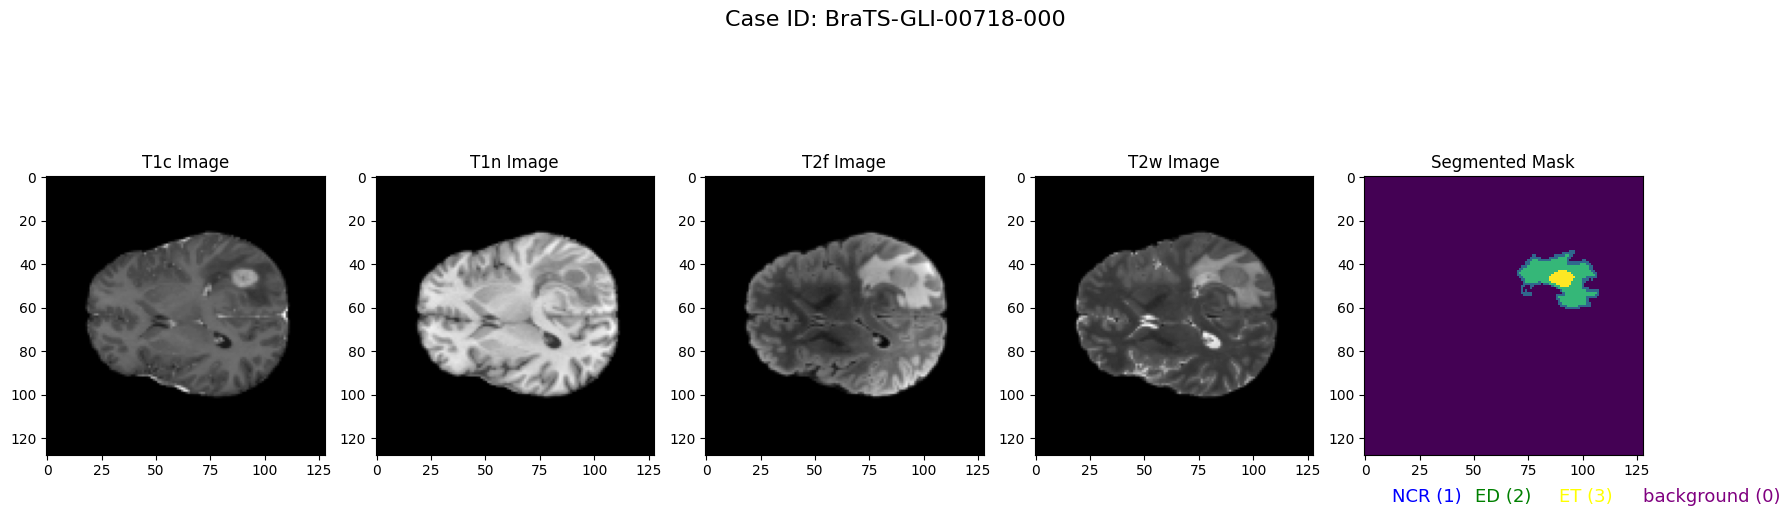

In [ ]:
# Select a random case ID
random_case_id = random.choice(all_case_ids)

# Create a generator for the selected case
selected_case_generator = data_generator([random_case_id], batch_size=1)

# Get a batch of data for the selected case
batch_images, batch_masks = next(selected_case_generator)

# Extract images and segmented mask individually
t1c_image = batch_images[0, :, :, 0]
t1n_image = batch_images[0, :, :, 1]
t2f_image = batch_images[0, :, :, 2]
t2w_image = batch_images[0, :, :, 3]
segmented_mask = batch_masks[0, :, :, :]

# Create a figure with subplots
fig, plot = plt.subplots(1, 5, figsize=(18, 6))

# Display the case ID as a header
fig.suptitle(f'Case ID: {random_case_id}', fontsize=16)

# Display the images and segmented mask
plot[0].imshow(t1c_image, cmap='gray')
plot[0].set_title('T1c Image')
plot[1].imshow(t1n_image, cmap='gray')
plot[1].set_title('T1n Image')
plot[2].imshow(t2f_image, cmap='gray')
plot[2].set_title('T2f Image')
plot[3].imshow(t2w_image, cmap='gray')
plot[3].set_title('T2w Image')
plot[4].imshow(segmented_mask.argmax(axis=-1), cmap='viridis', interpolation='nearest')
plot[4].set_title('Segmented Mask')

# Add text annotations for label interpretation below the segmented mask subplot
labels_text = ["NCR (1)", "ED (2)", "ET (3)", "background (0)"]
colors = ['blue', 'green', 'yellow', 'purple']
for label_idx, (label_text, color) in enumerate(zip(labels_text, colors)):
    plot[4].text(0.1 + label_idx * 0.3, -0.17, label_text, color=color, fontsize=13, transform=plot[4].transAxes)

plt.tight_layout()
plt.show()


In [ ]:

input_size = (128, 128, 4)  #input size to match the shape of images and masks
num_classes = 4  # Number of segmentation classes

# Build U-Net model
dropout = 0.2
hn = 'he_normal'

def unet(input_size, num_classes):
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=hn, input_shape=input_size)(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=hn)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=hn)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=hn)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=hn)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=hn)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=hn)(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=hn)(conv4)
    drop4 = Dropout(dropout)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=hn)(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=hn)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer=hn)(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=hn)(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=hn)(conv6)

    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer=hn)(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=hn)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=hn)(conv7)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer=hn)(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=hn)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=hn)(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer=hn)(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=hn)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=hn)(conv9)

    conv10 = Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs, conv10)  # Output should be conv10
    return model

model = unet(input_size, num_classes)
model.summary()


print("Input shape:", model.input.shape)
print("Output shape:", model.output.shape)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 64  2368        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_24 (Conv2D)             (None, 128, 128, 64  36928       ['conv2d_23[0][0]']              
                                )                                                           

In [ ]:
# Load model
load_path = '/content/drive/MyDrive/brats/model.h5'
loaded_model = tf.keras.models.load_model(load_path)

# Compile the loaded model with the same configuration as before training
loaded_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=4),
             tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)


In [ ]:
# Training Loop
batch_size = 16
num_epochs = 100

def lr_schedule(epoch, initial_lr=1e-4, decay_factor=0.5, decay_steps=10):
    if epoch < decay_steps:
        return initial_lr
    else:
        return initial_lr * (decay_factor ** (epoch // decay_steps))

# Define a callback to save weights
checkpoint_callback = ModelCheckpoint('/content/drive/MyDrive/brats/weights.h5', monitor='val_loss', save_best_only=True)

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define the EarlyStopping callback
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)

# Split the dataset into training and validation sets
train_case_ids, val_case_ids = train_test_split(all_case_ids, test_size=0.2, random_state=42)

# Initialize the training generator
train_generator_instance = data_generator(train_case_ids, batch_size)

# Use the EarlyStopping and LearningRateScheduler callbacks in the model.fit call
history = loaded_model.fit(
    train_generator_instance,
    steps_per_epoch=len(train_case_ids) // batch_size,
    epochs=num_epochs,
    validation_data=data_generator(val_case_ids, batch_size),
    validation_steps=len(val_case_ids) // batch_size,
    callbacks=[earlystopper, lr_scheduler, checkpoint_callback]
)

# Plot the training history to visualize the learning progress
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()


Evaluate Model

In [ ]:
# Define the path to the Excel mapping file and the test data directory
excel_mapping_path = '/content/drive/MyDrive/brats/BraTS2023_2017_GLI_Mapping_Test.xlsx'
test_data_directory = '/content/drive/MyDrive/brats/test_data1/'

# Load the case IDs from the Excel mapping file
excel_data = pd.read_excel(excel_mapping_path)
test_case_ids = excel_data['BraTS2023'].dropna().tolist()



1/1 [==============================] - 8s 8s/step


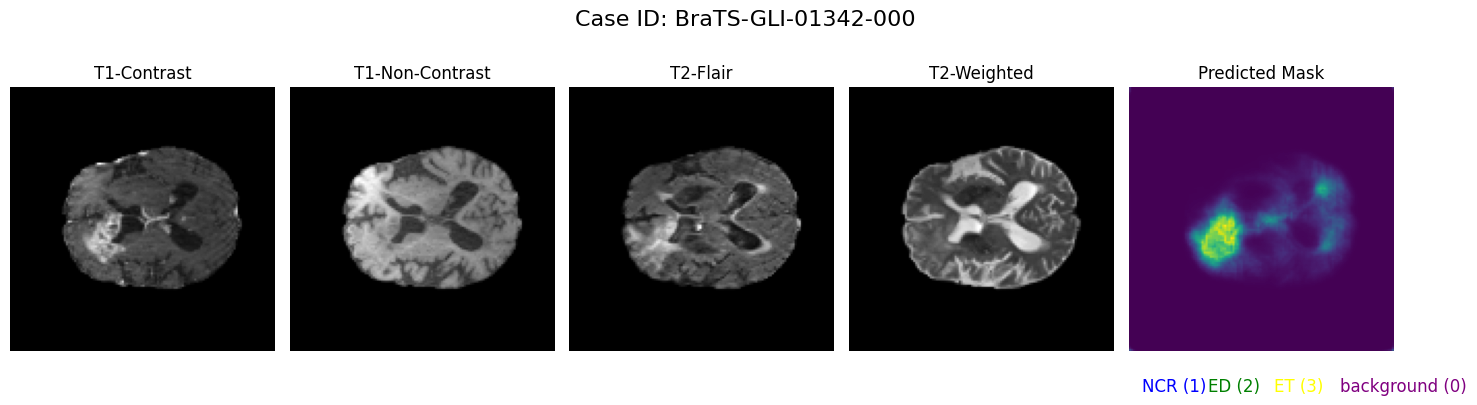

In [ ]:
# Define a test data generator function
def test_data_generator(case_ids, batch_size):
    num_cases = len(case_ids)
    while True:
        for i in range(0, num_cases, batch_size):
            batch_case_ids = case_ids[i:i + batch_size]
            batch_images = []

            for patient_id in batch_case_ids:
                images = []
                for image_type in ['t1c', 't1n', 't2f', 't2w']:
                    image_filename = f'{patient_id}-{image_type}.nii.gz'
                    image_path = os.path.join(test_data_directory, patient_id, image_filename)
                    nifti_image = nib.load(image_path)
                    image_data = nifti_image.get_fdata()

                    middle_slice = image_data.shape[2] // 2
                    slice_data = image_data[:, :, middle_slice]

                    resized_slice = resize(slice_data, (128, 128))
                    normalized_slice = (resized_slice - resized_slice.min()) / (resized_slice.max() - resized_slice.min())
                    images.append(normalized_slice)

                batch_images.append(np.stack(images, axis=-1))

            yield np.array(batch_images)

# define the batch size
test_batch_size = 16

# create the test data generator
test_data_generator = test_data_generator(test_case_ids, test_batch_size)

# generate one batch of data (containing 16 samples) for visualization
batch_images = next(test_data_generator)
predicted_masks_batch = loaded_model.predict(batch_images)  # Predicted masks for the batch

# pick random sample from the batch to display
sample_index = random.randint(0, test_batch_size - 1)  # Randomly select a sample
sample_image = batch_images[sample_index]
sample_predicted_mask = predicted_masks_batch[sample_index]

# get case ID for a selected sample
sample_case_id = test_case_ids[sample_index]

# create a figure with subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 4))

# Display the case ID as a header
fig.suptitle(f'Case ID: {sample_case_id}', fontsize=16)

# Display the input images with titles
image_titles = ['T1-Contrast', 'T1-Non-Contrast', 'T2-Flair', 'T2-Weighted']
for i in range(4):
    axs[i].imshow(sample_image[:, :, i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(image_titles[i])

# Display the predicted segmented mask
axs[4].imshow(sample_predicted_mask[:, :, 1], cmap='viridis')
axs[4].axis('off')
axs[4].set_title('Predicted Mask')

# Add text annotations labels
labels_text = ["NCR (1)", "ED (2)", "ET (3)", "background (0)"]
colors = ['blue', 'green', 'yellow', 'purple']
for label_idx, (label_text, color) in enumerate(zip(labels_text, colors)):
    axs[4].text(0.05 + label_idx * 0.25, -0.15, label_text, color=color, fontsize=12, transform=axs[4].transAxes)

plt.tight_layout()
plt.show()
